In [1]:
import numpy as np
from numpy import asarray
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import pydotplus as pyd

import keras
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras import optimizers
from keras.utils import to_categorical
from keras.models import Model
from keras import backend as K
from keras.models import load_model
from keras.layers import Dense, Input, Flatten, Embedding, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Activation, concatenate
from keras.utils import plot_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

%matplotlib inline

# Dataset loading - 1

In [2]:
train_data = pd.read_csv('data/final/clean_train.csv')
test_data = pd.read_csv('data/final/clean_test.csv')
train_data.head()

,text,tag
0,that rutgers game was an abomination an affron...,anger
1,i get mad over something so minuscule i try to...,anger
2,i get mad over something so minuscule i try to...,anger
3,eyes have been dilated i hate the world right ...,anger
4,one chosen by the clp members mp seats are not...,anger


In [3]:
train_data['text'] = train_data['text'].apply(str)
test_data['text'] = test_data['text'].apply(str)

train_data['tag'] = train_data['tag'].apply(lambda x: ['fear', 'joy', 'anger', 'sadness'].index(x))
test_data['tag'] = test_data['tag'].apply(lambda x: ['fear', 'joy', 'anger', 'sadness'].index(x))

In [7]:
X_train = train_data['text'].values
X_test = test_data['text'].values

y_train = train_data['tag'].values
y_test = test_data['tag'].values

X_train, X_cross_val, y_train, y_cross_val = train_test_split(X_train, y_train, test_size=0.2, random_state=40, stratify=y_train)

In [8]:
unique, counts = np.unique(y_train, return_counts=True)
print("Composition for training dataset")
for i in range(len(unique)):
    print(f"{unique[i]} : {counts[i]}")

Composition for training dataset
0 : 455
1 : 333
2 : 327
3 : 317


In [9]:
unique, counts = np.unique(y_cross_val, return_counts=True)
print("Composition for cross validation dataset")
for i in range(len(unique)):
    print(f"{unique[i]} : {counts[i]}")

Composition for cross validation dataset
0 : 114
1 : 83
2 : 82
3 : 79


In [10]:
unique, counts = np.unique(y_test, return_counts=True)
print("Composition for test dataset")
for i in range(len(unique)):
    print(f"{unique[i]} : {counts[i]}")

Composition for test dataset
0 : 471
1 : 356
2 : 348
3 : 327


In [11]:
t = Tokenizer()
t.fit_on_texts(X_train)
enc_train = t.texts_to_sequences(X_train)
enc_cross_val = t.texts_to_sequences(X_cross_val)
enc_test = t.texts_to_sequences(X_test)


In [12]:
size_vocabulary = len(t.word_index) + 1
print(size_vocabulary)

4635


In [13]:
pad_cross_val = pad_sequences(enc_cross_val, maxlen=140, padding='post')
pad_test = pad_sequences(enc_test, maxlen=140, padding='post')
pad_train = pad_sequences(enc_train, maxlen=140, padding='post')

In [14]:
y_cross_val = to_categorical(y_cross_val, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)
y_train = to_categorical(y_train, num_classes=4)

In [16]:
# load the whole embedding into memory
embeddings_index = dict()
fil = open('glove.twitter.27B.200d.txt', encoding = "utf8")
for vakya in fil:
    value = vakya.split()
    shabd = value[0]
    coefs = asarray(value[1:], dtype='float32')
    embeddings_index[shabd] = coefs

fil.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 1193514 word vectors.


In [17]:
# create a weight matrix for words in training docs
matrix_embedding = np.zeros((size_vocabulary, 200))
for word, i in t.word_index.items():
    try:
        embedding_vector = embeddings_index[word]
    except:
        embedding_vector = [0]*200
    
    matrix_embedding[i] = embedding_vector
        
matrix_embedding.shape

(4635, 200)

In [18]:
#  To handle case of division by zero, custom precision, recall and f1 score have been defined

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [19]:
data_inp = Input(shape=(140,), name='main_input')
layer_embed = Embedding(size_vocabulary, 200, weights=[matrix_embedding], trainable=False)(data_inp)
conv_layer_1 = Conv1D(filters=50, kernel_size=3, activation='relu')(layer_embed)
max_layer_1 = MaxPooling1D(pool_size=2)(conv_layer_1)
conv_layer_2 = Conv1D(filters=100, kernel_size=2, activation='relu')(max_layer_1)
max_layer_2 = MaxPooling1D(pool_size=2)(conv_layer_2)
flatten_layer = Flatten()(max_layer_2)
dense = Dense(150, activation='relu', name='fully_connected')(flatten_layer)
out_layer = Dense(4, activation='softmax')(dense)

model_one = Model(inputs=[data_inp], outputs=[out_layer])

print(model_one.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 140)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 140, 200)          927000    
_________________________________________________________________
conv1d (Conv1D)              (None, 138, 50)           30050     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 69, 50)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 68, 100)           10100     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 34, 100)           0         
_________________________________________________________________
flatten (Flatten)            (None, 3400)              0     

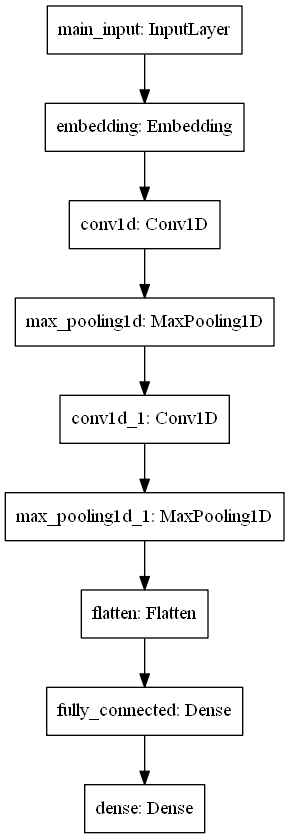

In [20]:
plot_model(model_one, to_file='model_one.png')

In [21]:
check_point = ModelCheckpoint("models/emo_model.h5", mode="max", monitor="val_f1_m", verbose=1, save_best_only = True)
early_stop = EarlyStopping(mode="max", monitor = 'val_f1_m', patience = 5, min_delta = 0,  verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5, monitor='val_f1_m', verbose=10, mode = 'max',  min_lr=0.0001)

In [23]:
c = optimizers.Adam(lr = 0.0001)
model_one.compile(optimizer=c, loss='categorical_crossentropy', metrics=[f1_m, 'acc'])

h1 = model_one.fit(pad_train, y_train, verbose=1, epochs=50, batch_size=16, callbacks=[check_point, early_stop, reduce_lr], 
               validation_data=(pad_cross_val, y_cross_val))

Epoch 1/50
90/90 [==============================] - 4s 29ms/step - loss: 1.3770 - f1_m: 0.0000e+00 - acc: 0.3274 - val_loss: 1.3609 - val_f1_m: 0.0000e+00 - val_acc: 0.3324

Epoch 00001: val_f1_m improved from -inf to 0.00000, saving model to models\emo_model.h5
Epoch 2/50
90/90 [==============================] - 2s 23ms/step - loss: 1.3362 - f1_m: 0.0000e+00 - acc: 0.3691 - val_loss: 1.3453 - val_f1_m: 0.0000e+00 - val_acc: 0.3547

Epoch 00002: val_f1_m did not improve from 0.00000
Epoch 3/50
90/90 [==============================] - 2s 24ms/step - loss: 1.3081 - f1_m: 5.4161e-04 - acc: 0.3867 - val_loss: 1.3090 - val_f1_m: 0.0153 - val_acc: 0.3883

Epoch 00003: val_f1_m improved from 0.00000 to 0.01535, saving model to models\emo_model.h5
Epoch 4/50
90/90 [==============================] - 2s 23ms/step - loss: 1.1931 - f1_m: 0.0896 - acc: 0.4871 - val_loss: 1.2283 - val_f1_m: 0.1536 - val_acc: 0.4274

Epoch 00004: val_f1_m improved from 0.01535 to 0.15357, saving model to models\emo_m

[[335  17  71  48]
 [ 31 273  30  22]
 [ 60  14 248  26]
 [ 86  23  37 181]]


<AxesSubplot:>

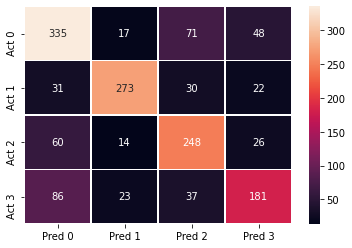

In [25]:
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(model_one.predict(pad_test), axis=1))

print(conf_matrix)
sns.heatmap(conf_matrix, annot=True, fmt='g', linewidths=.4, yticklabels=['Act 0', 'Act 1', 'Act 2', 'Act 3'],  
            xticklabels=['Pred 0', 'Pred 1', 'Pred 2', 'Pred 3'])

In [26]:
score_model_one = model_one.evaluate(pad_test, y_test)
print(model_one.metrics_names)
print(score_model_one)

47/47 [==============================] - 0s 9ms/step - loss: 0.9417 - f1_m: 0.6882 - acc: 0.6904
['loss', 'f1_m', 'acc']
[0.9416749477386475, 0.6881604194641113, 0.6904127597808838]


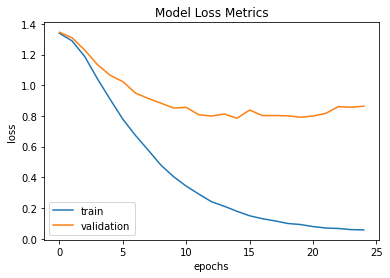

In [27]:
plt.plot(h1.history['loss'][1:])
plt.plot(h1.history['val_loss'][1:])
plt.title('Model Loss Metrics')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train','validation'], loc='lower left')
plt.show()

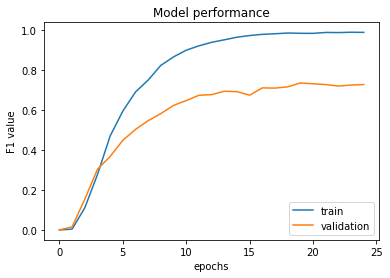

In [28]:
plt.plot(h1.history['f1_m'][1:])
plt.plot(h1.history['val_f1_m'][1:])
plt.title('Model performance')
plt.ylabel('F1 value')
plt.xlabel('epochs')
plt.legend(['train','validation'], loc='lower right')
plt.show()
